这是一个综合测试，将会结合前面学习到的相关回归分析方法，完成一个多元回归分析任务。同时，我们将结合 NumPy，scikit-learn，SciPy，statsmodels 等库，复习不同方法的实现及应用。

首先，先下载并预览数据集

In [3]:
import pandas as pd
import requests
from io import StringIO

url = "https://cdn.aibydoing.com/aibydoing/files/advertising.csv"

# 模拟浏览器头
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

# 发送HTTP请求并获取响应
response = requests.get(url, headers=headers)

# 将响应内容解析为DataFrame
df = pd.read_csv(StringIO(response.text))

df.head()

,Unnamed: 0,tv,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


数据集包含 4 列，共 200 行。每个样本代表某超市销售相应单位件商品所需要支出的广告费用。以第一行为例，表示该超市平均销售 22.1 件商品，需要支出的电视广告费用，广播广告费用以及报刊广告费用为：230.1 美元，37.8 美元和 69.2 美元。

所以，本次挑战将前 3 列视作特征，最后一列视作目标值。

In [12]:
import numpy as np
from scipy.optimize import leastsq

p_init = np.random.rand(2)

def func(p, x):
    a, b = p
    return a + x*b

def err_func(p, x, y):
    return func(p, x) - y

params_tv = leastsq(err_func, p_init, args=(df.tv, df.sales))
params_radio = leastsq(err_func, p_init, args=(df.radio, df.sales))
params_newspaper = leastsq(err_func, p_init, args=(df.newspaper, df.sales))

params_tv[0], params_radio[0], params_newspaper[0]

(array([7.03259355, 0.04753664]),
 array([9.31163812, 0.20249578]),
 array([12.35140704,  0.0546931 ]))

接下来，我们根据最小二乘法求得的结果，将拟合直线绘制到原分布散点图中

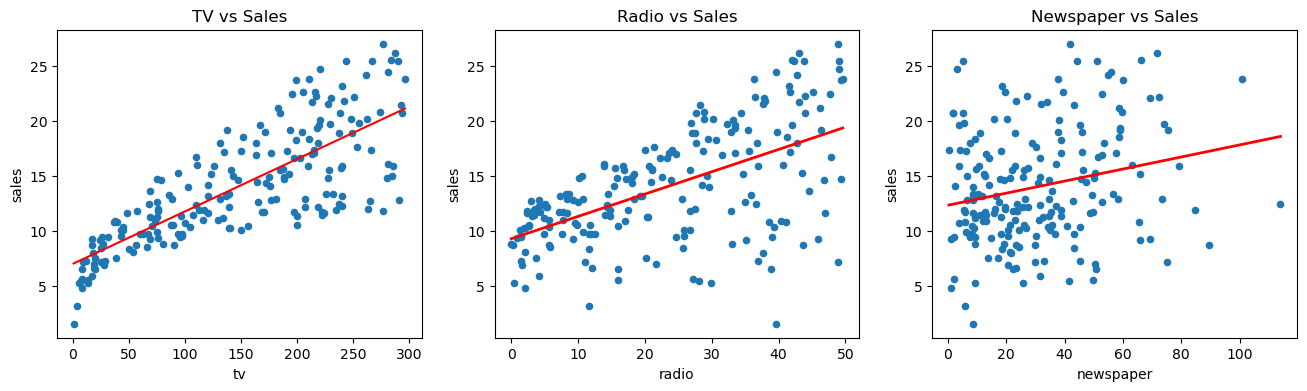

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(16, 4)) 

df.plot(kind='scatter', x='tv', y='sales', ax=axes[0], title='TV vs Sales')
df.plot(kind='scatter', x='radio', y='sales', ax=axes[1], title='Radio vs Sales')
df.plot(kind='scatter', x='newspaper', y='sales', ax=axes[2], title='Newspaper vs Sales')

x_tv = np.array([df.tv.min(), df.tv.max()])
axes[0].plot(x_tv, params_tv[0][1]*x_tv + params_tv[0][0], color='red')

x_radio = np.array([df.radio.min(), df.radio.max()])
axes[1].plot(x_radio, params_radio[0][1]*x_radio + params_radio[0][0], color='red', linewidth=2)

x_newspaper = np.array([df.newspaper.min(), df.newspaper.max()])
axes[2].plot(x_newspaper, params_newspaper[0][1]*x_newspaper + params_newspaper[0][0], color='red', linewidth=2)


接下来，我们尝试建立包含全部特征的多元线性回归模型
$$y = w_0 + w_1*tv + w_2*radio + w_3*newspaper$$

In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

X = df[['tv', 'radio', 'newspaper']]
y = df.sales
model.fit(X, y)

model.coef_, model.intercept_

(array([ 0.04576465,  0.18853002, -0.00103749]), 2.9388893694594103)

接下来，我们希望对多元线性回归模型进行检验。使用 statsmodels 库提供的相关方法来完成拟合优度检验和变量显著性检验。

In [15]:
import statsmodels.formula.api as smf

results = smf.ols(formula='sales~tv + radio + newspaper', data=df).fit()

results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.896   
Dependent Variable: sales            AIC:                780.3622
Date:               2025-03-06 11:04 BIC:                793.5555
No. Observations:   200              Log-Likelihood:     -386.18 
Df Model:           3                F-statistic:        570.3   
Df Residuals:       196              Prob (F-statistic): 1.58e-96
R-squared:          0.897            Scale:              2.8409  
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       2.9389    0.3119   9.4223  0.0000   2.3238  3.5540
tv              0.0458    0.0014  32.8086  0.0000   0.0430  0.0485
radio           0.1885    0.0086  21.8935  0.0000   0.1715  0.2055
newspaper      -0.0010    0.0059  -0.1767  0.8599  -0.0126  0.0105
-----------------------------------------------------------------
Omnibus:             60.414       Durbin-Watson:          2.084  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       151.241
Skew:                -1.327       Prob(JB):               0.000  
Kurtosis:            6.332        Condition No.:          454    
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""